# Requirements

In [1]:
import tokenizers

print(tokenizers.__version__)


0.15.2


In [2]:
import transformers
print(transformers.__version__)


4.38.2


In [3]:
from transformers import AutoModel, AutoTokenizer, BertTokenizerFast,BertForTokenClassification, BertForMaskedLM, BertForNextSentencePrediction, pipeline
from pprint import pprint 

In [4]:
tokenizer_matsci = AutoTokenizer.from_pretrained('m3rg-iitd/matscibert', do_lower_case=False)
tokenizer_bert = BertTokenizerFast.from_pretrained('bert-base-cased', do_lower_case=False)
tokenizer_mat = BertTokenizerFast.from_pretrained('./models/matbert-base-cased', do_lower_case=False)

In [5]:
"""
model_mask : BertForMaskedLM for matcibert
model_ns : BertForNextSentencePrediction for matbert
model_tc : BertForTokenClassification for matcibert
The AutoModel class converts the token encodings to embeddings, and then feeds them through the encoder stack to return the hidden states
"""
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #Run on the GPU
model = AutoModel.from_pretrained('m3rg-iitd/matscibert')
model_mask_bert = BertForMaskedLM.from_pretrained('bert-base-uncased')
model_mask_matsc = BertForMaskedLM.from_pretrained('m3rg-iitd/matscibert')
model_mask_mat = BertForMaskedLM.from_pretrained('./models/matbert-base-cased')
model_mask_bert_uncased = BertForMaskedLM.from_pretrained('./models/matbert-base-uncased')
model_ns = BertForNextSentencePrediction.from_pretrained('./models/matbert-base-cased')
model_tc = BertForTokenClassification.from_pretrained("m3rg-iitd/matscibert")

Some weights of BertModel were not initialized from the model checkpoint at m3rg-iitd/matscibert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertFor

# Data extraction

In [6]:
import pandas as pd

file_2 = './bow.xlsx'

df = pd.read_excel(file_2, sheet_name='Ingr')
df_pro = pd.read_excel(file_2, sheet_name='Prop')
df_pro['Material property'] = df_pro['Material property'].str.lower()	
df['Component'] = df['Component'].str.lower()


organic_compounds_df = df[df['Master Class'] == 'Organic compounds']
polysaccharides_df = df[df['Master Class'] == 'Polysaccharides']
inorganic_compounds_df = df[df['Master Class'] == 'Inorganic compounds']
plasticizer_df = df[df['Master Class'] == 'Plasticizer/Crosslinking agent']



filtered_organic_compounds_df = organic_compounds_df[['Component']].drop_duplicates()
filtered_polysaccharides_df = polysaccharides_df[['Component']].drop_duplicates()
filtered_inorganic_compounds_df = inorganic_compounds_df[['Component']].drop_duplicates()
property_df = df_pro[['Material property']].drop_duplicates()
filtered_plasticizer_df = plasticizer_df[['Component']].drop_duplicates()
combined_df = pd.concat([filtered_organic_compounds_df, filtered_inorganic_compounds_df], axis=0)




# Sentences experiments

In [7]:
pipe = pipeline('fill-mask', model="./models/matbert-base-cased", top_k=8, tokenizer=tokenizer_mat)

description = "the first film generated by mixtures of agar biopolymer, glycerol plasticizer and water"
prompt = "the tested product showed poor [MASK] properties"
output = pipe(description + prompt)
for element in output:
 print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

Token mechanical:	0.617%
Token barrier:	0.129%
Token film:	0.027%
Token physical:	0.024%
Token tensile:	0.020%
Token adhesion:	0.011%
Token adhesive:	0.010%
Token antimicrobial:	0.008%


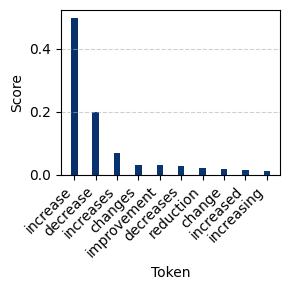

In [9]:
"""
Visualization of different prompt distribution scores

"""
import matplotlib.pyplot as plt
pipe = pipeline('fill-mask', model=model_mask_mat, tokenizer=tokenizer_mat, top_k=100)



prompt_A="The membranes made with galactoglucomannan and tripolyphosphate. By adding of barbatimao microcapsules cd , [MASK] in their water vapor permeability "
prompt_B="The film generated by mixtures galactoglucomannan and xylitol. By adding of barbatimao microcapsules cd, [MASK] in their water vapor permeability"
prompt_C="The films demonstrated that adding lysozyme, the rice with ethylene glycol present [MASK] water vapor permeability"
prompt_D="The membranes demonstrated that adding chitin additive, the rice with sorbital present [MASK] water vapor permeability"


output = pipe(prompt_A)
output = output[:10]

token_str_all = [element['token_str'] for element in output]
scores_all = [element['score'] for element in output]



top_20_indices = sorted(range(len(scores_all)), key=lambda k: scores_all[k], reverse=True)[:20]
token_str_top_20 = [token_str_all[i] for i in top_20_indices]
scores_top_20 = [scores_all[i] for i in top_20_indices]


plt.figure(figsize=(3, 3))
cmap = plt.get_cmap('Blues_r')
colors = [cmap(i) for i in range(len(scores_top_20))]

plt.bar(token_str_top_20, scores_top_20, color=colors, width=0.3)  
plt.xlabel('Token') 
plt.ylabel('Score')  
plt.grid(axis='y', linestyle='--', alpha=0.6)  


plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Use of ingredient combinations

In [ ]:

prompts = []
description = "the film generated by mixtures of {alginato} and {Component}"
prompt = " showed [MASK] elongation at break"


for _, row in df.iterrows():
    component = row['Component']
    prompt_f = description.format(alginato='alginato', Component=component) + prompt
    prompts.append(prompt_f)

pipe = pipeline('fill-mask', model=model_mask_mat, tokenizer=tokenizer_mat, top_k=100)


results = [pipe(p) for p in prompts]

probabilities = []
target_words = ["higher", "high", "good", "excellent", "best", "low", "weak", "poor"]

for result in results:
    prompt_probabilities = {word: 0.0 for word in target_words}
    for suggestion in result:
        sequence = suggestion['sequence'].lower()
        for word in target_words:
            if word in sequence:
                prompt_probabilities[word] = suggestion['score']
                break
    probabilities.append(prompt_probabilities)


probabilities_df = pd.DataFrame(probabilities, columns=target_words)

df = pd.concat([df, probabilities_df], axis=1)


print(df)


            Master Class                               Class  \
0      Organic compounds                   Organic compounds   
1      Organic compounds                   Organic compounds   
2      Organic compounds                   Organic compounds   
3      Organic compounds                   Organic compounds   
4      Organic compounds            Organic compounds - acid   
..                   ...                                 ...   
349              Protein                             Protein   
350  Inorganic compounds                      Minerals salts   
351  Inorganic compounds                      Minerals salts   
352    Organic compounds  Organic compounds - Essencial Oils   
353    Organic compounds                   Organic compounds   

                    Component                   Variant Abbreviation/Other  \
0               acacia lignin             Acacia lignin                NaN   
1                        acai                      Acai                NaN 

C:\Users\fveli\AppData\Local\Temp\ipykernel_19052\1109447323.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.46004632115364075' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  correlation_matrix.loc[component1, component2] = score
C:\Users\fveli\AppData\Local\Temp\ipykernel_19052\1109447323.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.43141984939575195' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  correlation_matrix.loc[component1, component2] = score
C:\Users\fveli\AppData\Local\Temp\ipykernel_19052\1109447323.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.4069589674472809' has dtype incompatible with int64, please explicitly cast t

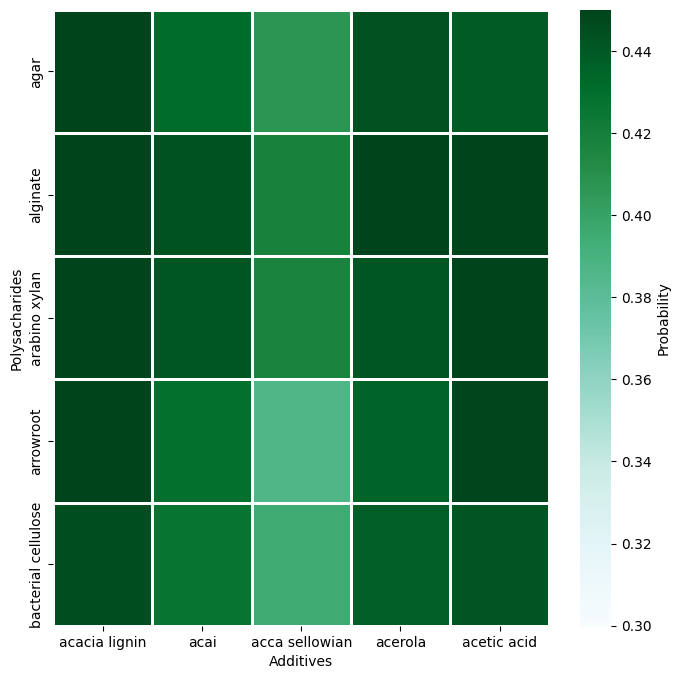

In [ ]:

pipe = pipeline('fill-mask', model=model_mask_mat, tokenizer=tokenizer_mat)

prompt_template = "The membranes made with {Component1} and glycerol. By adding of {Component2}, [MASK] in their water vapor permeability."

component_list = combined_df['Component'].tolist()[:5]
polysaccharide_component_list = filtered_polysaccharides_df['Component'].tolist()[:5]

correlation_matrix = pd.DataFrame(0, index=polysaccharide_component_list,columns=component_list, )


for i, component1 in enumerate(polysaccharide_component_list):
    for j, component2 in enumerate(component_list):
        prompt = prompt_template.format(Component1=component1, Component2=component2)
        output = pipe(prompt)
        score = 0.3
        for element in output:
            if element['token_str'] == 'increase':
                score = element['score']
                break
        

        correlation_matrix.loc[component1, component2] = score


plt.figure(figsize=(8, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='BuPu', center=0.5, fmt=".2f")
sns.heatmap(correlation_matrix,
            annot=False, cmap="BuGn", fmt=".6f", linewidths=0.9, cbar_kws={'label': 'Probability'}, vmin=0.3, vmax=0.45)
plt.xlabel("Additives")
plt.ylabel("Polysacharides")
plt.show()

In [ ]:
"""
Combinations of three components
"""
pipe = pipeline('fill-mask', model=model_mask_mat, tokenizer=tokenizer_mat, top_k=1, device="cuda:0", batch_size=100 )

prompt_template= "The membranes made with {Component1} and {Component3}. By adding of {Component2}, [MASK] in their water vapor permeability."


polysaccharide_component_list = filtered_polysaccharides_df['Component'].tolist()
organic_component_list = filtered_organic_compounds_df['Component'].tolist()
plastic_component_list = filtered_plasticizer_df['Component'].tolist()

high_probability_mask_words = []


batch_size = 100
component_combinations = list(product(polysaccharide_component_list, organic_component_list, plastic_component_list))
num_batches = len(component_combinations) // batch_size

set_seed(42)  

for i in range(num_batches + 1):
    batch = component_combinations[i * batch_size: (i + 1) * batch_size]
    batch_prompts = [prompt_template.format(Component1=c1, Component2=c2, Component3=c3) for c1, c2, c3 in batch]
    results = pipe(batch_prompts)

    for (component1, component2, component3), output in zip(batch, results):
        for element in output:
            if element['score'] > 0.3:
                high_probability_mask_words.append((component1, component2, component3, element['token_str'], element['score']))


result_df = pd.DataFrame(high_probability_mask_words, columns=["Component1", "Component2", "Component3", "Mask Word", "Score"])
print(result_df)

In [8]:
from transformers import pipeline, set_seed
pipe = pipeline('fill-mask', model=model_mask_mat, tokenizer=tokenizer_mat, top_k=1, device="cuda:0", batch_size=100 )

prompt_template = "Membranes were prepared using alginate, a polysaccharide derived from seaweed, combined with glycerol as a plasticizer. When {Component2} was incorporated as a secondary additive, the water vapor permeability of the membrane [MASK], potentially affecting its suitability for packaging applications."

polysaccharide_component_list = filtered_polysaccharides_df['Component'].tolist()
organic_component_list = filtered_organic_compounds_df['Component'].tolist()
plastic_component_list = filtered_plasticizer_df['Component'].tolist()
# component_list = combined_df['Component'].tolist()

high_probability_mask_words = []

batch_size = 100
component_combinations = [(c2,) for c2 in organic_component_list] 
num_batches = len(component_combinations) // batch_size

set_seed(42)
for i in range(num_batches + 1):
    batch = component_combinations[i * batch_size: (i + 1) * batch_size]
    batch_prompts = [prompt_template.format(Component2=c2) for (c2,) in batch]
    results = pipe(batch_prompts)

    for (component2,), output in zip(batch, results):
        for element in output:
            if element['score'] > 0.3:
                high_probability_mask_words.append((component2, element['token_str'], element['score']))

result_df = pd.DataFrame(high_probability_mask_words, columns=["Component2", "Mask Word", "Score"])
print(result_df)

                   Component2  Mask Word     Score
0               acacia lignin  decreased  0.507611
1                        acai  decreased  0.514905
2              acca sellowian  decreased  0.514854
3                     acerola  decreased  0.502209
4                 acetic acid  decreased  0.506559
..                        ...        ...       ...
151                   xanthan  decreased  0.489531
152                      yams  decreased  0.514394
153        zataria multiflora  decreased  0.508000
154  ziziphora clinopodioides  decreased  0.497964
155                  zucchini  decreased  0.508991

[156 rows x 3 columns]
